In [70]:
import os
from preprocessing import *
import torch
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Grayscale
import matplotlib.pyplot as plt
from torch.optim import Adam
import numpy as np
import pylab as pl
from IPython import display
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.animation as animation
from skimage.transform import resize

from tqdm import tqdm

In [71]:
BASE_PATH = "c:\\Users\\Aina\\OneDrive\\Escritorio\\White-Matter-Hyperintensity-Segmentation"+ "\\ICPR"
TRAINING_PATH= BASE_PATH + "\\train\\"

TEST_PATH= BASE_PATH + "/test/"

In [72]:
TRAINING_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "pathsT2":[],
    "mask" :[]
}
createDictionary(TRAINING_PATH, TRAINING_DICT)
print(TRAINING_DICT.get("pathsFLAIR").__getitem__(0))
print(TRAINING_DICT.get("pathsT1").__getitem__(0))
print(TRAINING_DICT.get("pathsT2").__getitem__(0))
print(TRAINING_DICT.get("mask").__getitem__(0))
print(len(TRAINING_DICT.get("pathsFLAIR")))

c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\ICPR\train\P1\T1\P1_T1_FLAIR.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\ICPR\train\P1\T1\P1_T1_T1.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\ICPR\train\P1\T1\P1_T1_T2.nii.gz
c:\Users\Aina\OneDrive\Escritorio\White-Matter-Hyperintensity-Segmentation\ICPR\train\P1\T1\P1_T1_MASK.nii.gz
93


In [4]:
# TEST_DICT={
#     "pathsFLAIR":[],
#     "pathsT1":[],
#     "pathsT2":[],
#     "mask" :[],
# }
# createDictionary(TEST_PATH, TEST_DICT)
# print(TEST_DICT.get("pathsFLAIR").__getitem__(0))
# print(TEST_DICT.get("pathsT1").__getitem__(0))
# print(TEST_DICT.get("pathsT2").__getitem__(0))
# print(TEST_DICT.get("mask").__getitem__(0))

# DATASET

In [11]:
transform=transforms.Compose([
    transforms.ToTensor(),
])


In [73]:
train,val = getIDsICPR(TRAINING_DICT)

In [13]:
print(len(train.get('pathsFLAIR')))
print(len(val.get('pathsFLAIR')))

74
19


(182, 218, 182)


(-0.5, 181.5, 181.5, -0.5)

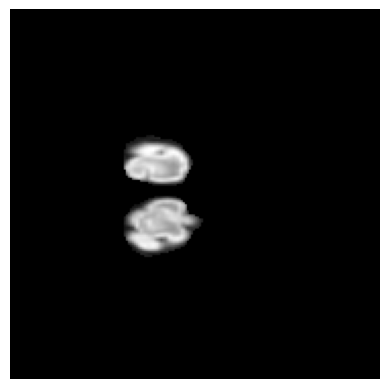

In [22]:
flair = nib.load(os.path.join(TRAINING_PATH, "P47", "T1", "P47_T1_FLAIR.nii.gz"))
flair_im= flair.get_fdata()
#flair_im = flair_im[39:-39,41:-41,39:-39] 
print(flair_im.shape)
plt.imshow(flair_im[:,25, :], cmap='gray')
plt.axis('off')

(182, 218, 182)


(-0.5, 181.5, 181.5, -0.5)

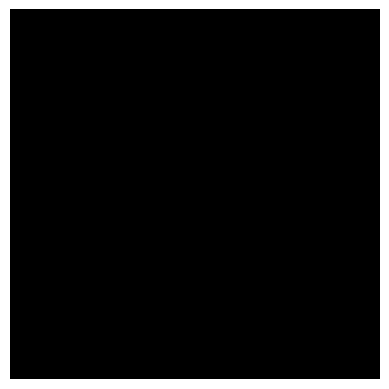

In [23]:
img = nib.load(os.path.join(TRAINING_PATH, "P48", "T1", "P48_T1_MASK.nii.gz"))
image_data = img.get_fdata() 
print(image_data.shape)
plt.imshow(image_data[:, 25 ,:], cmap='gray')
plt.axis('off')

# 3D-NET

In [74]:
train_data = ICPR(train.get("pathsFLAIR"),train.get("pathsT1"),train.get("pathsT2"), train.get("mask"),transform, transform)
val_data = ICPR(val.get("pathsFLAIR"),val.get("pathsT1"),val.get("pathsT2"), val.get("mask"),transform, transform)

In [75]:
train_dl = DataLoader(train_data, batch_size=1,num_workers=0,shuffle=True)
val_dl = DataLoader(val_data, batch_size=1,num_workers=0, shuffle=True)

In [76]:
from UNet3D import UNet3D 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D(in_channels=1, num_classes=1)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion.smooth = 1e-5
optimizer = Adam(model.parameters(), lr=0.0005)

In [10]:
def traintestpipeline(epochs: int, optim: Adam, criterion: DiceLoss, min_loss: int, name: str):
    t_loss = np.zeros((epochs))
    v_loss = np.zeros((epochs))
    pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
    for epoch in pbar:
        
        train_loss = 0 
        val_loss = 0  
        
        model.train()                                                  
        for batch_num, (input_img, target) in enumerate(train_dl, 1):   
        

            input_img= input_img.to(device).float()
            target = target.to(device).float()
            input_img=input_img.unsqueeze(0)
            
            output = model(input_img)
            loss = criterion(output.squeeze(), target.squeeze())
            loss.backward()                                            
            optim.step()                                               
            optim.zero_grad()     
            
            train_loss += loss.item()    
                                                        
        model.eval()   
        with torch.no_grad():                                          
            for input_img, target in val_dl: 
                input_img = input_img.to(device).float()
                target = target.to(device)
                input_img=input_img.unsqueeze(0)

                output = model(input_img)                                   
                loss = criterion(output.squeeze(), target.squeeze())   
                val_loss += loss.item()  
        
        # RESULTATS
        train_loss /= len(train_dl)
        t_loss[epoch-1] = train_loss
        
        val_loss /= len(val_dl)   
        v_loss[epoch-1] = val_loss
        if(v_loss[epoch-1]<min_loss):
            min_loss=v_loss[epoch-1]
            torch.save(model.state_dict(), name)  
        # VISUALITZACIO DINAMICA
        plt.figure(figsize=(12, 4))
        pl.plot(t_loss[:epoch], label="train")
        pl.plot(v_loss[:epoch], label="validation")
        pl.legend()
        pl.xlim(0, epochs)
        pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
        
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.close()

        pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")

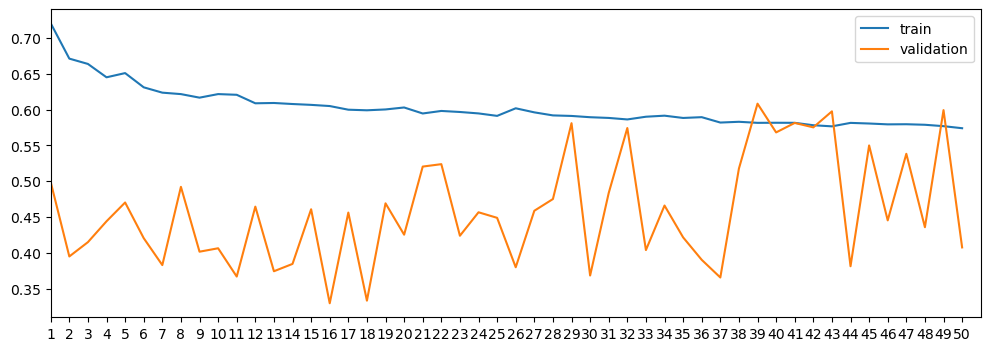

Epoch:50 Training Loss:0.5739595946176229 Validation Loss:0.4075060252523663: 100%|██████████| 50/50 [4:12:29<00:00, 302.98s/it]


In [11]:
traintestpipeline(50,optimizer,criterion,1000,"PRUEBAICPR.pt")

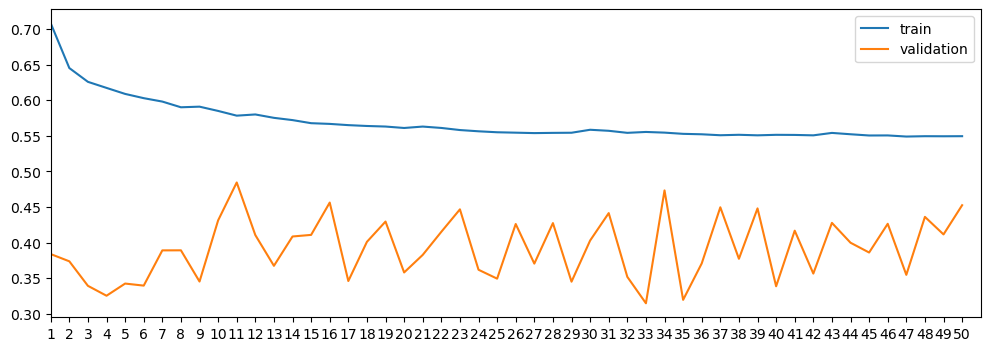

Epoch:50 Training Loss:0.5495138462582553 Validation Loss:0.45247346576145814: 100%|██████████| 50/50 [3:30:51<00:00, 253.04s/it]


In [12]:
model = UNet3D(in_channels=1, num_classes=1)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion.smooth = 1e-5
optimizer = Adam(model.parameters(), lr=0.00005)
traintestpipeline(50,optimizer,criterion,1000,"PRUEBAICPR2.pt")

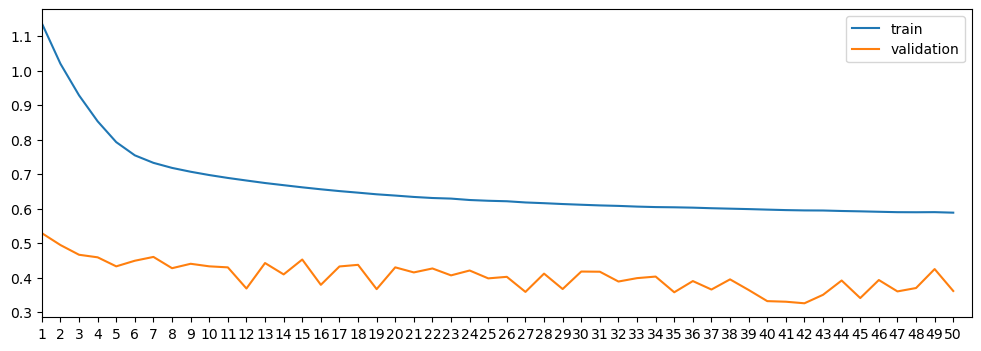

Epoch:50 Training Loss:0.5883482152948508 Validation Loss:0.3612310443696143: 100%|██████████| 50/50 [3:19:53<00:00, 239.87s/it] 


In [11]:
model = UNet3D(in_channels=1, num_classes=1)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
criterion.smooth = 1e-5
optimizer = Adam(model.parameters(), lr=0.000001)
traintestpipeline(50,optimizer,criterion,1000,"PRUEBAICPR3.pt")

In [77]:
model = UNet3D(in_channels=1, num_classes=1)
mmodel =  model.to(device)
mmodel.load_state_dict(torch.load("PRUEBAICPR3.pt"))
mmodel.eval()

UNet3D(
  (a_block1): Conv3DBlock(
    (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (a_block2): Conv3DBlock(
    (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, 

In [78]:
import numpy as np
from medpy import metric

def calculate_metric_percase(pred, gt):
    intersect = torch.sum(pred*gt)
    union = torch.sum(pred) + torch.sum(gt) - intersect
    if union == 0:
        return torch.tensor(0.0, device=pred.device)
    iou = torch.mean(intersect/union)
    
    y_true_f = gt.float()
    y_pred_f = pred.float()

    intersection = torch.sum(y_true_f * y_pred_f)
    union = torch.sum(y_true_f) + torch.sum(y_pred_f)
    if union == 0:
        return torch.tensor(0.0, device=y_pred_f.device)
    dice_coeff = (2. * intersection) / (union)

    return dice_coeff, iou

In [79]:
import torch

def calculate_metrics(model, test_dl, device):
    model.eval()
    total_dice = 0
    total_pre = 0
    total_rec = 0
    total_acc = 0
    total_iou=0
    total = len(test_dl)
    

    with torch.no_grad():
        for input_img, target in test_dl:
            input_img = input_img.to(device).float()
            target = target.to(device).float()
            input_img=input_img.unsqueeze(0)
            output = model(input_img)
            output = (output > 0.5).float()
            target= (target > 0.5).float()

            output = torch.unsqueeze(output, axis=0)
            target = torch.unsqueeze(target, axis=0)

            #output= output.detach().cpu().numpy()
            #target= target.detach().cpu().numpy()
            dice, iou= calculate_metric_percase(output,target)
            
            #dice = np.nan_to_num(dice.cpu().numpy())
            total_dice += dice
            
            
            
            


    total_dice /= total
    total_pre /=total
    total_rec /=total
    total_acc /=total
    total_iou /= total
    print("Dice coefficient:", total_dice)
    print("IOU:", total_iou)
    print("Precision:", total_pre)
    print("Recall:", total_rec)
    print("Accuracy:", total_acc)

In [80]:
calculate_metrics(mmodel, val_dl,device)

Dice coefficient: tensor(0.0743, device='cuda:0')
IOU: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.0


# GIF

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.animation as animation
def generador(loader):
    for data, target in loader:
        data, target = data.to(device).float(), target.float().to(device)
        yield data, target 
def showsegmentation(test_dl, mmodel):               
    with torch.no_grad():
        gen = generador(test_dl)

        data, true_labels = next(gen)
        data = data.unsqueeze(0)
        mmodel.eval()

        output = mmodel(data)

        #binary_mask_resized = output.squeeze().cpu().numpy()
        binary_mask_resized = true_labels.squeeze().cpu().numpy()
        print(binary_mask_resized.shape)
        verts,faces,_,_ = marching_cubes(binary_mask_resized, step_size=1)
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111,projection='3d')
        mesh = Poly3DCollection(verts[faces], alpha=0.9)
        face_color = [0.45,0.75, 0.45]
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)
        ax.set_xlim(0, binary_mask_resized.shape[0])
        ax.set_ylim(0, binary_mask_resized.shape[1])
        ax.set_zlim(0, binary_mask_resized.shape[2])
        #show 3 gifs 
    plt.tight_layout()
    plt.show()
        
        

In [31]:
showsegmentation(val_dl,mmodel)

(88, 88, 88)


https://www.youtube.com/watch?v=WBJH_B-CYLY&ab_channel=FatemehBehrad

Number of vertices: 8859
Number of faces: 17554


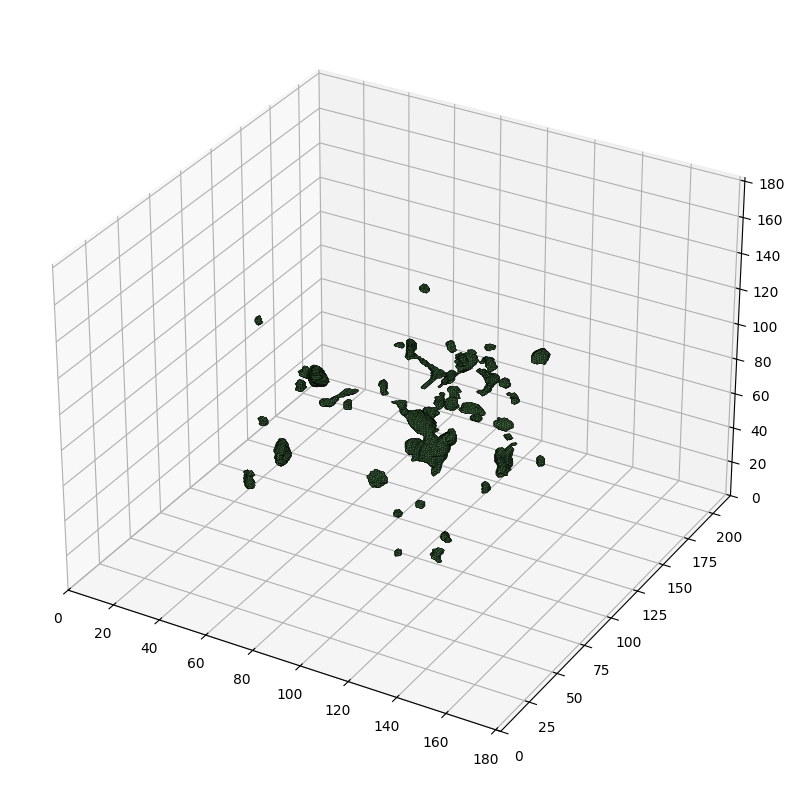

In [3]:
img = nib.load(os.path.join(TRAINING_PATH, "P48", "T1", "P48_T1_MASK.nii.gz"))
binary_mask = img.get_fdata() 
#binary_mask_resized = resize(binary_mask, (24, 24, 24), preserve_range=True)
binary_mask_resized = (binary_mask > 0).astype(int)

verts,faces,_,_ = marching_cubes(binary_mask_resized, step_size=1)
print("Number of vertices:", len(verts))
print("Number of faces:", len(faces))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
mesh = Poly3DCollection(verts[faces], alpha=0.6, linewidths=0.2, edgecolors='k')
face_color = [0.45,0.75, 0.45]
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)
ax.set_xlim(0, binary_mask_resized.shape[0])
ax.set_ylim(0, binary_mask_resized.shape[1])
ax.set_zlim(0, binary_mask_resized.shape[2])
def update(angle):
    ax.view_init(elev=10, azim=angle)

#ani = animation.FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
#ani.save('brain.gif', writer='pillow', fps=30)
plt.show()